
# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Junio 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el **Lunes 24 de junio**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen ABRIL 2024.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros
- numero de capas.
- numero de kernels.
- tamaño de kernels.


a) Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor.

b) Al mejor modelo, aplique capas de dropout para ver si puede mejorar sus métricas.



In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

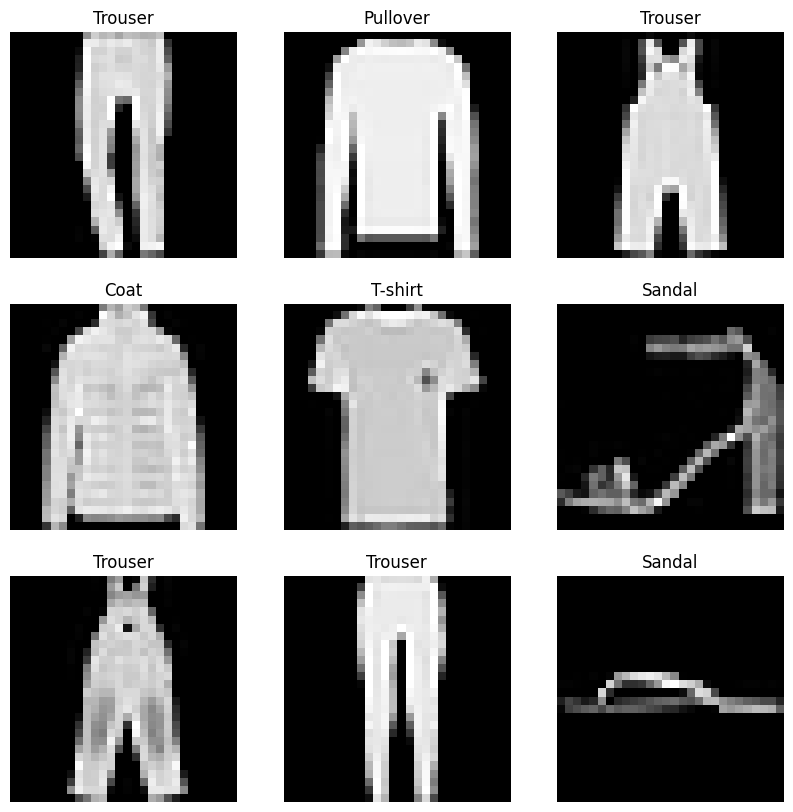

In [3]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [4]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
trainloader = DataLoader(train_data, batch_size=1024, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=1024, shuffle=True, num_workers=2)

In [5]:
train_data[0][0][0].shape

torch.Size([28, 28])

In [6]:
class ClothingPredictor(nn.Module):
    def __init__(self, classes_len=len(classes)):
        super(ClothingPredictor, self).__init__()
        self.cnn1 = nn.Sequential(
            # 28x28x1
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # 28x28x8
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # 28x28x16
        )
        self.cnn2 = nn.Sequential(
            # 28x28x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 14x14x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #7x7x64
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*64, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=classes_len),
        )

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.fc(x)
        return x

In [7]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(trainloader.dataset)
    return epoch_loss

In [8]:
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(testloader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy, all_labels, all_preds

In [9]:
def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)

In [10]:
def load_checkpoint(model, optimizer, path="checkpoint.pth"):
    if os.path.exists(path):
        state = torch.load(path)
        model.load_state_dict(state['model_state_dict'])
        optimizer.load_state_dict(state['optimizer_state_dict'])
        return state['epoch']
    else:
        return 0

In [11]:
model = ClothingPredictor()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
print(model)

ClothingPredictor(
  (cnn1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (cnn2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [12]:
train_losses = []
test_losses = []
test_accuracies = []

In [13]:
model.to(device)
epochs = 10
checkpoint_path = "checkpoint.pth"
start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
best_accuracy = 0

In [14]:
for epoch in range(start_epoch, epochs):
    train_loss = train(model, trainloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    test_loss, test_accuracy, all_labels, all_preds = evaluate(model, testloader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if (test_accuracy > best_accuracy):
      best_accuracy = test_accuracy
      save_checkpoint(model, optimizer, epoch + 1, checkpoint_path)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss / Test Loss: {train_loss:.4f} / {test_loss:.4f}")
    print(f"Test Accuracy: {100*test_accuracy:.2f}%")


Epoch 1/10 - Train Loss / Test Loss: 1.2009 / 0.5194
Test Accuracy: 82.18%
Epoch 2/10 - Train Loss / Test Loss: 0.6520 / 0.3888
Test Accuracy: 86.29%
Epoch 3/10 - Train Loss / Test Loss: 0.5249 / 0.3361
Test Accuracy: 88.80%
Epoch 4/10 - Train Loss / Test Loss: 0.4562 / 0.3039
Test Accuracy: 89.57%
Epoch 5/10 - Train Loss / Test Loss: 0.4098 / 0.2793
Test Accuracy: 90.34%
Epoch 6/10 - Train Loss / Test Loss: 0.3797 / 0.2629
Test Accuracy: 91.03%
Epoch 7/10 - Train Loss / Test Loss: 0.3568 / 0.2614
Test Accuracy: 90.95%
Epoch 8/10 - Train Loss / Test Loss: 0.3432 / 0.2650
Test Accuracy: 91.30%
Epoch 9/10 - Train Loss / Test Loss: 0.3261 / 0.2576
Test Accuracy: 91.44%
Epoch 10/10 - Train Loss / Test Loss: 0.3075 / 0.2415
Test Accuracy: 91.60%


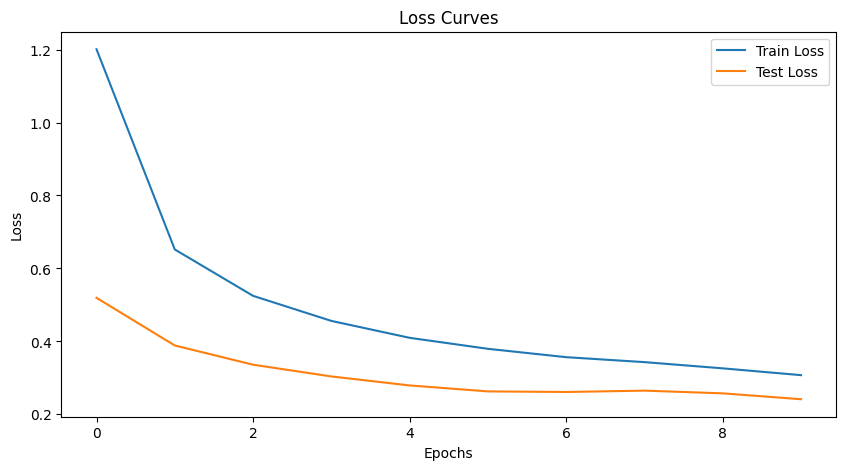

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

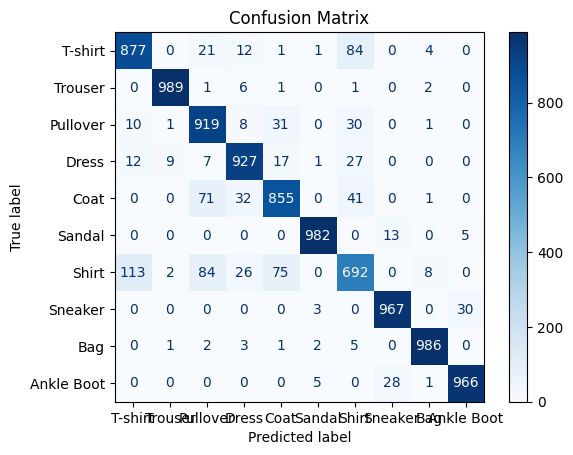

In [16]:
cm = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) e identificar los números mayores o menores a 4,5.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. (al reducir el train set, mantenga equilibrada la distribución de las clases!!)

Pruebe 2 estrategias de transfer learning distintas (acorde a los visto en la teoría) y comente para cada una, cual debería funcionar mejor justificando su respuesta.


Compare los resultados finales y comente.

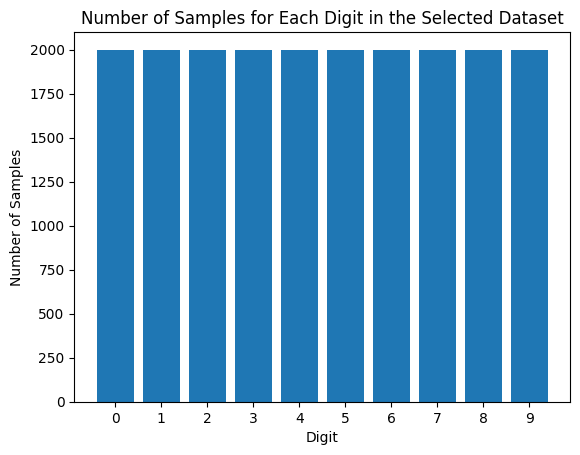

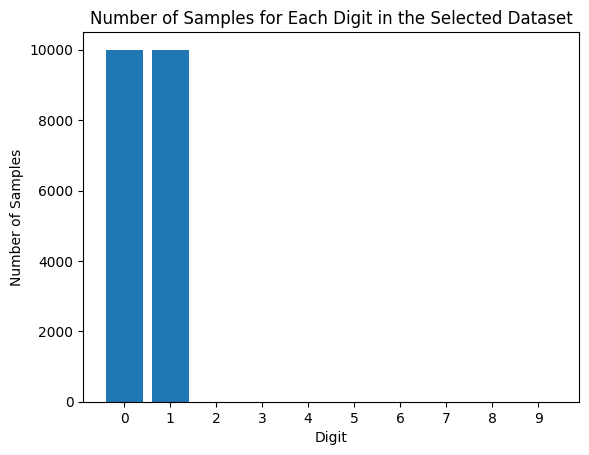

In [17]:
# Download train data from open datasets.
train_data2 = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor(),)

indices_by_class = [np.where(train_data2.targets == i)[0] for i in range(10)]
num_samples_per_class = 20000 // 10
selected_indices = [np.random.choice(indices, num_samples_per_class, replace=False) for indices in indices_by_class]
selected_indices = np.concatenate(selected_indices)
np.random.shuffle(selected_indices)

train_data2.data = train_data2.data[selected_indices]
train_data2.targets = train_data2.targets[selected_indices]

counts = np.bincount(train_data2.targets.numpy(), minlength=10)
plt.bar(range(10), counts)
plt.xlabel('Digit')
plt.ylabel('Number of Samples')
plt.title('Number of Samples for Each Digit in the Selected Dataset')
plt.xticks(range(10))
plt.show()

train_data2.targets = (train_data2.targets > 4).long()
counts = np.bincount(train_data2.targets.numpy(), minlength=10)
plt.bar(range(10), counts)
plt.xlabel('Digit')
plt.ylabel('Number of Samples')
plt.title('Number of Samples for Each Digit in the Selected Dataset')
plt.xticks(range(10))
plt.show()

# Download test data from open datsets.
test_data2 = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor(),)
test_data2.targets = (test_data2.targets > 4).long()

In [18]:
trainloader2 = DataLoader(train_data2, batch_size=1024, shuffle=True, num_workers=2)
testloader2 = DataLoader(test_data2, batch_size=1024, shuffle=True, num_workers=2)

In [19]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()
        
        optimizer.zero_grad(set_to_none=True)

        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(trainloader.dataset)
    return epoch_loss

In [20]:
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(testloader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy, all_labels, all_preds

In [21]:
# Cambiamos los output features de la ultima capa del modelo (para que predigan si el numero es > 4.5 o no)
model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*64, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
# Congelamos el primer bloque de convolucion
model.cnn1.requires_grad_(False)

# El optimizador se mantiene
optimizer2 = optim.Adam(model.parameters(), lr=1e-3)
criterion2 = nn.BCELoss()

In [22]:
print(model)

ClothingPredictor(
  (cnn1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (cnn2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [23]:
train_losses2 = []
test_losses2 = []
test_accuracies2 = []

In [24]:
model.to(device)
epochs = 5
checkpoint_path2 = "checkpoint2.pth"
start_epoch = load_checkpoint(model, optimizer2, checkpoint_path2)
best_accuracy2 = 0

In [25]:
for epoch in range(start_epoch, epochs):
    train_loss = train(model, trainloader2, criterion2, optimizer2, device)
    test_loss, test_accuracy, all_labels2, all_preds2 = evaluate(model, testloader2, criterion2, device)

    train_losses2.append(train_loss)
    test_losses2.append(test_loss)
    test_accuracies2.append(test_accuracy)

    if (test_accuracy > best_accuracy2):
      best_accuracy2 = test_accuracy
      save_checkpoint(model, optimizer2, epoch + 1, checkpoint_path2)
      print("Saving.")

    print(f"Epoch {epoch+1}/{epochs} - Train Loss / Test Loss: {train_loss:.4f} / {test_loss:.4f}")
    print(f"Test Accuracy: {100*test_accuracy:.2f}%")

Saving.
Epoch 1/5 - Train Loss / Test Loss: 0.4252 / 0.1801
Test Accuracy: 93.20%
Saving.
Epoch 2/5 - Train Loss / Test Loss: 0.1603 / 0.1126
Test Accuracy: 95.90%
Saving.
Epoch 3/5 - Train Loss / Test Loss: 0.1031 / 0.0865
Test Accuracy: 96.84%
Saving.
Epoch 4/5 - Train Loss / Test Loss: 0.0804 / 0.0713
Test Accuracy: 97.34%
Saving.
Epoch 5/5 - Train Loss / Test Loss: 0.0592 / 0.0662
Test Accuracy: 97.67%


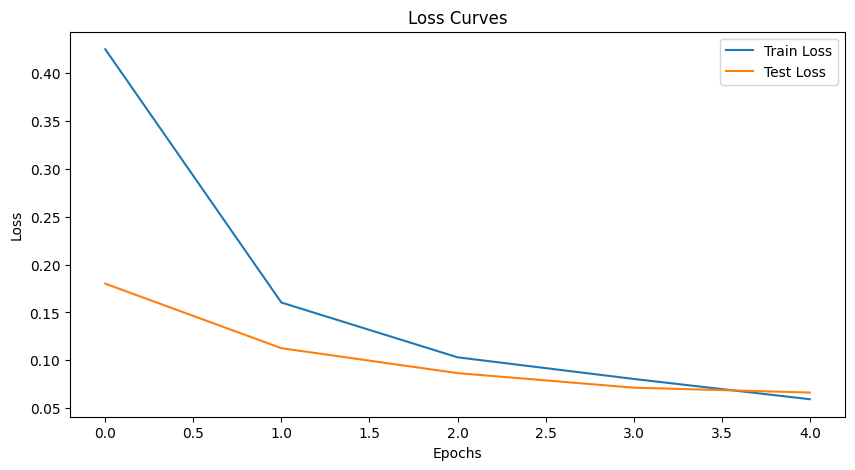

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses2, label='Train Loss')
plt.plot(test_losses2, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

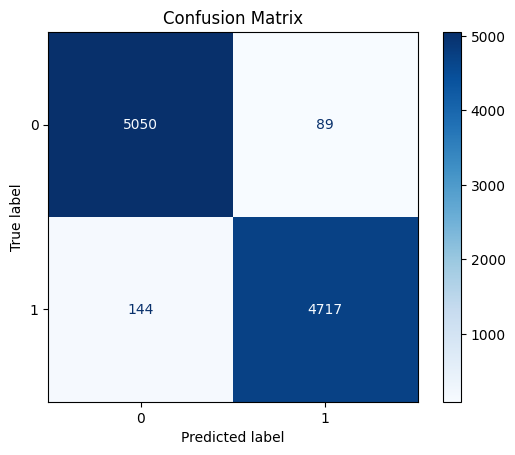

In [27]:
cm = confusion_matrix(all_labels2, all_preds2)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [28]:
model = ClothingPredictor()
load_checkpoint(model, optimizer, "checkpoint.pth")

# Cambiamos los output features de la ultima capa del modelo (para que predigan si el numero es > 4.5 o no)
model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*64, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

# El optimizador se mantiene
optimizer2 = optim.Adam(model.parameters(), lr=1e-3)
criterion2 = nn.BCELoss()

In [29]:
train_losses3 = []
test_losses3 = []
test_accuracies3 = []

In [30]:
model.to(device)
epochs = 5
checkpoint_path3 = "checkpoint3.pth"
start_epoch = load_checkpoint(model, optimizer2, checkpoint_path3)
best_accuracy3 = 0

In [31]:
for epoch in range(start_epoch, epochs):
    train_loss = train(model, trainloader2, criterion2, optimizer2, device)
    test_loss, test_accuracy, all_labels3, all_preds3 = evaluate(model, testloader2, criterion2, device)

    train_losses3.append(train_loss)
    test_losses3.append(test_loss)
    test_accuracies3.append(test_accuracy)

    if (test_accuracy > best_accuracy3):
      best_accuracy3 = test_accuracy
      save_checkpoint(model, optimizer2, epoch + 1, checkpoint_path3)
      print("Saving.")

    print(f"Epoch {epoch+1}/{epochs} - Train Loss / Test Loss: {train_loss:.4f} / {test_loss:.4f}")
    print(f"Test Accuracy: {100*test_accuracy:.2f}%")

Saving.
Epoch 1/5 - Train Loss / Test Loss: 0.4148 / 0.1739
Test Accuracy: 93.34%
Saving.
Epoch 2/5 - Train Loss / Test Loss: 0.1602 / 0.1098
Test Accuracy: 96.01%
Saving.
Epoch 3/5 - Train Loss / Test Loss: 0.1057 / 0.0775
Test Accuracy: 97.30%
Epoch 4/5 - Train Loss / Test Loss: 0.0743 / 0.0792
Test Accuracy: 97.29%
Saving.
Epoch 5/5 - Train Loss / Test Loss: 0.0581 / 0.0581
Test Accuracy: 98.03%


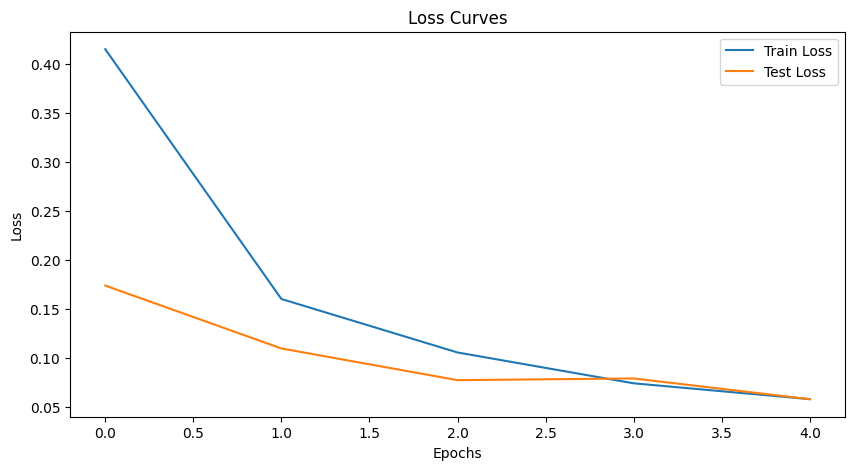

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses3, label='Train Loss')
plt.plot(test_losses3, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

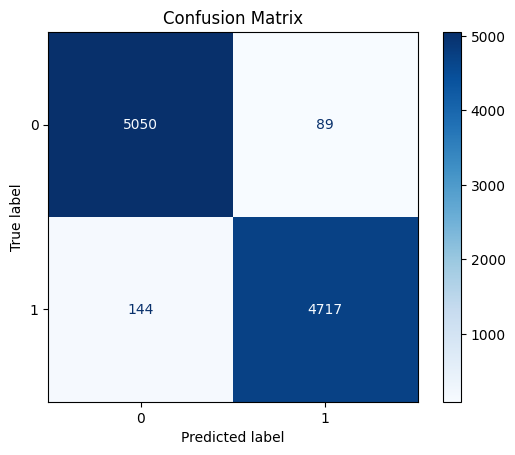

In [33]:
cm = confusion_matrix(all_labels2, all_preds2)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()